In [206]:
import numpy as np
import matplotlib.pyplot as plt
from tensor.operation.kruskal import kruskal
from tensor.operation.khatri_rao import khatri_rao
from tensor.operation.matricize import matricize
from tensor.operation.sampled_khatri_rao_prod import SKR
from tensor.operation.sampled_matricize import Sampled_Matricize
import tensorly as tly

Algorithm: CP RAND

$\text{Input:}$ $\mathcal{X} \in \mathbb{R}^{I_1 \times \cdots \times I_N}$, $\mathbf{R}$, $\mathbf{S}$

$\text{Output:}$ $\boldsymbol{\lambda}$, $\{\mathbf{A}^{(n)}\}$

$
\textbf{CPRAND} (\mathcal{X}, \mathbf{R}, \mathbf{S}):\\
\quad \text{Initialize factor matrices } \mathbf{A}^{(2)}, \dots, \mathbf{A}^{(N)}\\
\quad \textbf{repeat}:\\
\quad \quad \text{for } n = 1, \dots, N \text{ do}:\\
\quad \quad \quad \text{Define sampling operator} \mathbf{S} \in \mathbb{R}^{S \times \prod_{m \neq n} I_m}\\
\quad \quad \quad \mathbf{Z}_S \gets \text{SKR}(\mathbf{S}, \mathbf{A}^{(1)}, \dots, \mathbf{A}^{(n-1)}, \mathbf{A}^{(n+1)}, \dots, \mathbf{A}^{(N)})\\
\quad \quad \quad \mathbf{X}^T_S \gets \mathbf{S} \mathbf{X}^T_{(n)}\\
\quad \quad \quad \mathbf{A}^{(n)} \gets \underset{\mathbf{A}}{\arg \min} \lVert \mathbf{Z}_S \mathbf{A}^T - \mathbf{X}^T_S \rVert_F\\
\quad \quad \quad \text{Normalize columns of } \mathbf{A}^{(n)} \text{ and update } \boldsymbol{\lambda}\\
\quad \quad \textbf{end for}\\
\quad \textbf{until convergence}\\
\quad \text{Return } \boldsymbol{\lambda}, \{\mathbf{A}^{(n)}\}\\
$


In [207]:
class CP_RAND:
    def __init__(self, tensor: np.ndarray, rank :int, max_iter=10000, eps=0.01,initalisation:str ="random"):
        """
        PARAFAC decompositon, it initializes the maximum amount of iterations that 
        are done along with the tolerance value for the convergence
        it also takes the size of the core tensor `rank`
        """
        #Original Tensor
        self.tensor = tensor

        #Rank of decomposition being targeted
        self.rank = rank
        
        #Max iterations
        self.max_iter = max_iter

        #Stopping error value
        self.eps = eps

        #sets the type of initialisation
        self.init_type=initalisation
        #Stores the errrors at each step
        self.errors = []
        #Factor matrixes
        self.factors = []

        #Current lamda value
        self.lamda = np.ones(self.rank)
         
    def fit(self):
        #training loop,self explanatory
        self._init_factors()
        for i in range(self.max_iter):
            for mode in (range(self.tensor.ndim)):
                self._update_factors(mode)
            if self._is_converged():
                break
        print("Converged in {} iterations".format(i+1))
        # print("Final error = ", self.errors[-1])
    
    def _init_factors(self):
        """
        initialize the factors using the `rank` many left singular 
        vectors of the corresponding mode-n matricization of the input tensor
        """
        if self.init_type == 'random':
            self.factors = [np.random.rand(self.tensor.shape[i], self.rank) for i in range(self.tensor.ndim)]
        elif self.init_type == 'hosvd':
            self.factors = []
            for i in range(self.tensor.ndim):
                M = np.linalg.svd(matricize(self.tensor, i))[0]
                if M.shape[1] < self.rank:
                    M_ = np.zeros((M.shape[0], self.rank - M.shape[1]))
                    M = np.concatenate((M, M_), axis=1)
                else:
                    M = M[:, :self.rank]
                self.factors.append(M)
        else:
            raise Exception("Invalid initialisation method")
    
    def _update_factors(self, mode):
        """
        Update the factors per iteration for the `mode`'th Factor
        """
        tot_row=1
        for x in range(self.tensor.ndim):
            if x!=mode:
                tot_row*=self.tensor.shape[x]
        S=10*self.rank
        #Very weird behaviour for this one
        sel_rows=np.random.choice(tot_row,S,replace=True)
        
        #This converges quite well
        # sel_rows=np.random.permutation(tot_row)

        Z_s=SKR(sel_rows,self.factors,mode)
        X_s=Sampled_Matricize(sel_rows,self.tensor,mode)
        # print(X_s.shape)
        # print(Z_s.shape)
        # print(len(sel_rows))
        # print(self.rank)
        self.factors[mode]=X_s @ np.linalg.pinv(Z_s.T)
        # print(self.factors[mode].shape)
        
        col_norms = np.linalg.norm(self.factors[mode], axis=0)

        self.factors[mode] = self.factors[mode] / col_norms # normalize the self.factors[mode]
        
        self.lamda=col_norms
    
    def _is_converged(self):
        """
        check if the algorithm has converged
        by computing the Frobenius norm of the difference between the current tensor
        and the tensor obtained by multiplying the factors
        """
        tmp=self.factors[0]
        
        self.factors[0] =self.factors[0]* self.lamda
        estim = kruskal(*self.factors)
        error = np.linalg.norm(self.tensor - estim)
        print("Error = ", error)
        self.errors.append(error)
        self.factors[0]=tmp
        return error < self.eps
    
    def plot_errors(self):
        plt.plot(self.errors)
        plt.legend(["Errors"])
        plt.xlabel("Iterations")
        plt.ylabel("Frobenius norm")
        plt.show()

In [208]:
X = np.random.rand(2,3,4)
R = 3
tly_ans=tly.decomposition.parafac(X,rank=R)
X_tly=tly.cp_to_tensor(tly_ans)
print("tensorly error is {}:".format(np.linalg.norm(X-X_tly)))
solver=CP_RAND(X,R,int(1e3),0.01,"random")
solver.fit()
# print(factors[0].shape, factors[1].shape, factors[2].shape)


tensorly error is 0.29750627894665344:
Error =  1.2244166722063161
Error =  1.0517681326958974
Error =  1.0752024147183448
Error =  0.9824790058299565
Error =  0.9075772591771769
Error =  0.7267379136533254
Error =  0.532156746202939
Error =  0.46739955030485675
Error =  0.44244534311031664
Error =  0.4166792548160548
Error =  0.474111860327856
Error =  0.4571487347612833
Error =  0.4004152373277295
Error =  0.4002085073343255
Error =  0.37125053098845273
Error =  0.3850356946059784
Error =  0.3826714618855379
Error =  0.38011374346997107
Error =  0.38708263478576144
Error =  0.382609769988279
Error =  0.43810015472819674
Error =  0.4139755371385245
Error =  0.4055313516571757
Error =  0.4119126891481888
Error =  0.38565878850192603
Error =  0.4265974822959967
Error =  0.37369395307252706
Error =  0.3606311016031554
Error =  0.411902494786031
Error =  0.3674681252839687
Error =  0.3568079299100043
Error =  0.4029838099605961
Error =  0.3592963184419089
Error =  0.336834514997202
Error 

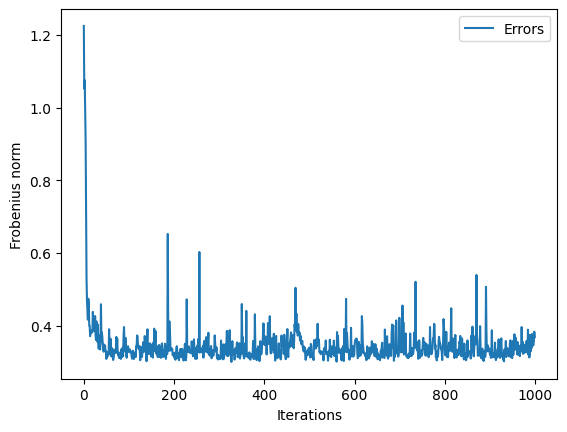

In [209]:


solver.plot_errors()